# QPU Execution

*What you will learn:*

- How execution of a sequence on a QPU differs from executing it on an emulator
- How to execute a sequence on a QPU
- How to use parametrized sequences

## Introduction

When the time comes to execute a Pulser sequence, there are many options: one can choose to execute it on a QPU or on an emulator, which might happen locally or remotely. All these options are accessible through an unified interface we call a `Backend`. 

This tutorial is a step-by-step guide on how to use a QPU backend for sequence execution. Since we recommend always testing on an emulator first, please make sure you've followed the tutorial [Execution on an Emulator](backends.nblink) first.

## 1. Preparation for execution on  `QPUBackend`

Sequence execution on a QPU is done through the `QPUBackend`, which is a remote backend. Therefore, it requires a remote backend connection, which should be open from the start due to two additional QPU constraints:

1. The `Device` must be chosen among the options available at the moment, which can be found through `connection.fetch_available_devices()`.
2. If in the chosen device `Device.requires_layout` is `True`, the `Register` must be defined from a register layout:  
    -  If `Device.accepts_new_layouts` is `False`, use one of the register layouts calibrated for the chosen `Device` (found under `Device.calibrated_register_layouts`). Check out [this tutorial](reg_layouts.nblink) for more information on how to define a `Register` from a `RegisterLayout`.
    - Otherwise, we may choose to define our own custom layout or rely on `Register.with_automatic_layout()` to
    give us a register from an automatically generated register layout that fits our desired register while obeying the device constraints. 


Let us first create the `Connection` and fetch the `FRESNEL` `Device`.

In [ ]:
from pulser_pasqal import PasqalCloud

connection = PasqalCloud(
    username=USERNAME,  # Your username or email address for the Pasqal Cloud Platform
    project_id=PROJECT_ID,  # The ID of the project associated to your account
    password=PASSWORD,  # The password for your Pasqal Cloud Platform account
)
print(connection.fetch_available_devices())
device = connection.fetch_available_devices()["FRESNEL_CAN1"]

{'FRESNEL_CAN1': FRESNEL_CAN1, 'FRESNEL_RD': FRESNEL_RD, 'FRESNEL': FRESNEL}


Now we can check what options we have for working with layouts. Firstly, we can see that using a layout is required.

In [2]:
device.requires_layout

True

`FRESNEL` does allow us to define new layouts, which will allow us to just create the desired register from an automatic layout.

In [3]:
device.accepts_new_layouts

True

## 2. Creating the Pulse Sequence
Let's create the same sequence as in [Execution on an Emulator](backends.nblink). The one difference with before is the call to `Register.with_automatic_layout`.

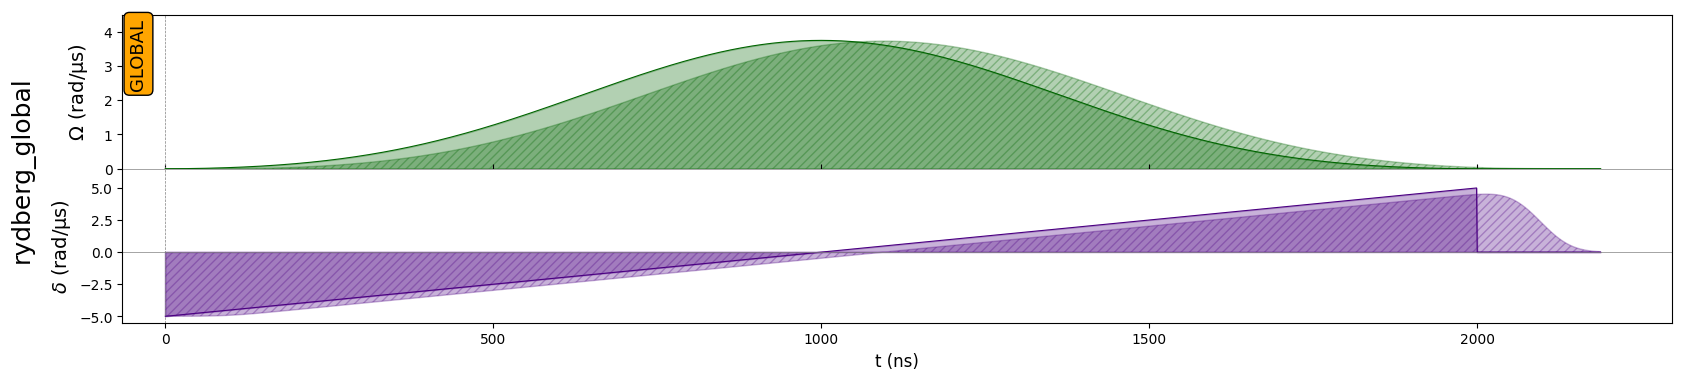

In [4]:
import numpy as np
import pulser

bare_reg = pulser.Register({"q0": (-5, 0), "q1": (5, 0)})

reg = bare_reg.with_automatic_layout(device)

seq = pulser.Sequence(reg, device)
seq.declare_channel("rydberg_global", "rydberg_global")
t = 2000  # ns

amp_wf = pulser.BlackmanWaveform(t, np.pi)
det_wf = pulser.RampWaveform(t, -5, 5)
seq.add(pulser.Pulse(amp_wf, det_wf, 0), "rydberg_global")

seq.draw()

## 3. Running on a QPU

Now that we have an appropriate sequence tied to a device, having the device run the sequence is very similar to having an emulator run it. We create a `QPUBackend`, which being a remote backend will require the `Sequence` and the `Connection`. However, since it's not an emulator, the `QPUBackend` does not take a configuration object.

In [5]:
backend = pulser.backends.QPUBackend(seq, connection)

Just as for a remote emulator backend, the `run` method of `QPUBackend` requires a `job_params`. In this case, `runs` is actually used, and it dictates the number of times that the `Sequence` is run on the QPU. A single bitstring is measured at the end of each run. More are not possible since measuring bitstrings destroys the quantum state, and the sequence will have to be run again.

In [6]:
job_params = [{"runs": 1000}]
results = backend.run(job_params=job_params)

We can now print the results as they come in, just as for emulator backends.

In [7]:
results.get_available_results()

{'b874299e-dd4f-4cde-85bd-86aeefd0d06c': SampledResult(atom_order=('q0', 'q1'), total_duration=0, _results={UUID('00000000-0000-0000-0000-000000000000'): [Counter({'11': 634, '10': 163, '01': 150, '00': 53})]}, _times={UUID('00000000-0000-0000-0000-000000000000'): [1.0]}, _aggregation_methods={UUID('00000000-0000-0000-0000-000000000000'): <AggregationMethod.BAG_UNION: 3>}, _tagmap={'bitstrings': UUID('00000000-0000-0000-0000-000000000000')}, meas_basis='ground-rydberg', bitstring_counts={'11': 634, '10': 163, '01': 150, '00': 53}, evaluation_time=1.0)}

The QPU only returns bitstrings at the final time, and as for emulator backends, there is a dedicated method for accessing them.

In [8]:
print(results[0].final_bitstrings)

Counter({'11': 634, '10': 163, '01': 150, '00': 53})


## 4. Using parametrized sequences

When running on the QPU, since the queue can be very long, it is advantageous to batch runs together to the extent possible. This means results are conveniently grouped for inspection after the batch is done. For sequences composed of the same series of `Pulse`s, with the same `Register` this is possible using [parametrized sequences](./paramseqs.nblink). Let us demonstrate how this works by taking the `Sequence` defined in section 2, and making the duration `t` a parameter. We will then submit two jobs in a single batch, using different values for `t`. In the absence of noise and interactions, the sequence above should yield only the bitstring `11`, so let us compare how the bitstring count `11` depends on `t`.

In [9]:
param_seq = pulser.Sequence(reg, device)
param_seq.declare_channel("rydberg_global", "rydberg_global")
t_param = param_seq.declare_variable("t", dtype=int)

amp_wf_param = pulser.BlackmanWaveform(t_param, np.pi)
det_wf_param = pulser.RampWaveform(t_param, -5, 5)
param_seq.add(pulser.Pulse(amp_wf_param, det_wf_param, 0), "rydberg_global")

We can now plot the sequence only after we specify a value for `t`. Let us put `t=2000` and show that the sequence is identical to that in section 2.

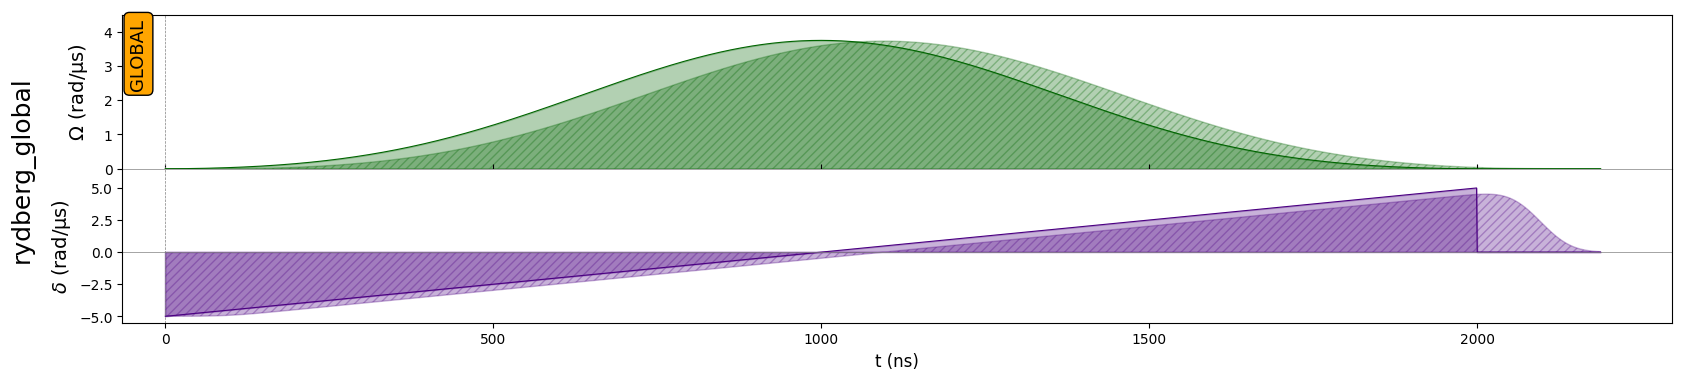

In [10]:
seq_2000 = param_seq.build(t=2000)
seq_2000.draw()

We can now submit jobs with different values of `t` by leveraging the `job_params` argument of `QPUBackend.run`. However, to do that we must first create a new `QPUBackend` with the parameterized sequence.

In [ ]:
param_backend = pulser.backends.QPUBackend(param_seq, connection)
param_job_params = [
    {"runs": 1000, "variables": {"t": 1000}},
    {"runs": 1000, "variables": {"t": 2000}},
]
param_results = param_backend.run(job_params=param_job_params)

Once again, we can see the results as they come in. Note that since we now specify 2 jobs in the `job_params` we expect two results in total.

In [12]:
param_results.get_available_results()

{'3c43919c-bfea-40e2-9e9b-0dc74d724ee1': SampledResult(atom_order=('q0', 'q1'), total_duration=0, _results={UUID('00000000-0000-0000-0000-000000000000'): [Counter({'11': 742, '10': 118, '01': 113, '00': 27})]}, _times={UUID('00000000-0000-0000-0000-000000000000'): [1.0]}, _aggregation_methods={UUID('00000000-0000-0000-0000-000000000000'): <AggregationMethod.BAG_UNION: 3>}, _tagmap={'bitstrings': UUID('00000000-0000-0000-0000-000000000000')}, meas_basis='ground-rydberg', bitstring_counts={'11': 742, '10': 118, '01': 113, '00': 27}, evaluation_time=1.0),
 '2458ae1a-9f3a-444b-bab6-cf611a7eb538': SampledResult(atom_order=('q0', 'q1'), total_duration=0, _results={UUID('00000000-0000-0000-0000-000000000000'): [Counter({'11': 702, '01': 136, '10': 134, '00': 28})]}, _times={UUID('00000000-0000-0000-0000-000000000000'): [1.0]}, _aggregation_methods={UUID('00000000-0000-0000-0000-000000000000'): <AggregationMethod.BAG_UNION: 3>}, _tagmap={'bitstrings': UUID('00000000-0000-0000-0000-000000000000

We can once again print the final bitstrings. And we see that in this case the shorter pulse has more bitstrings on the `11` state. However, the `t=2000` is a repeat of the run in section 3, and these two runs show a difference of 10% in the `11` count. The difference in counts between `t=1000` and `t=2000` is well within that margin.

In [13]:
print("t=1000:", param_results[0].final_bitstrings)
print("t=2000:", param_results[1].final_bitstrings)

t=1000: Counter({'11': 742, '10': 118, '01': 113, '00': 27})
t=2000: Counter({'11': 702, '01': 136, '10': 134, '00': 28})
